In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error , r2_score
import numpy as np
import joblib

# Load data
df = pd.read_csv("/kaggle/input/anomaly/anomaly_detection (1).csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

# Create lag features for TDS (window size = 3)
df["TDS_t-1"] = df["TDS"].shift(1)
df["TDS_t-2"] = df["TDS"].shift(2)
df["TDS_t-3"] = df["TDS"].shift(3)
df["TDS_diff"] = df["TDS"].diff().fillna(0)
df["TDS_rollmean_3"] = df["TDS"].rolling(window=3).mean().bfill()
df["TDS_rollstd_3"] = df["TDS"].rolling(window=3).std().fillna(0)
# Drop rows with NaNs from shift
df = df.dropna().reset_index(drop=True)


In [3]:
# ✅ Features & Target
X = df[
    [
         "turbidity", "temperature", "pH",
        "ph_dev", "tds_temp_ratio", "turbidity_x_ph", "temp_sqr",
        "tds_diff", "temp_diff", "ph_diff",
        "tds_rollmean_3", "ph_rollstd_3"
    ]
]

y = df["TDS"]

# Train-Test Split
split_idx = int(0.8 * len(df))
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

In [4]:
# 🔥 Train Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 🔮 Predict
y_pred = model.predict(X_test)

📉 MAE: 8.83
📉 RMSE: 28.81
🧠 R² Score: 0.9696


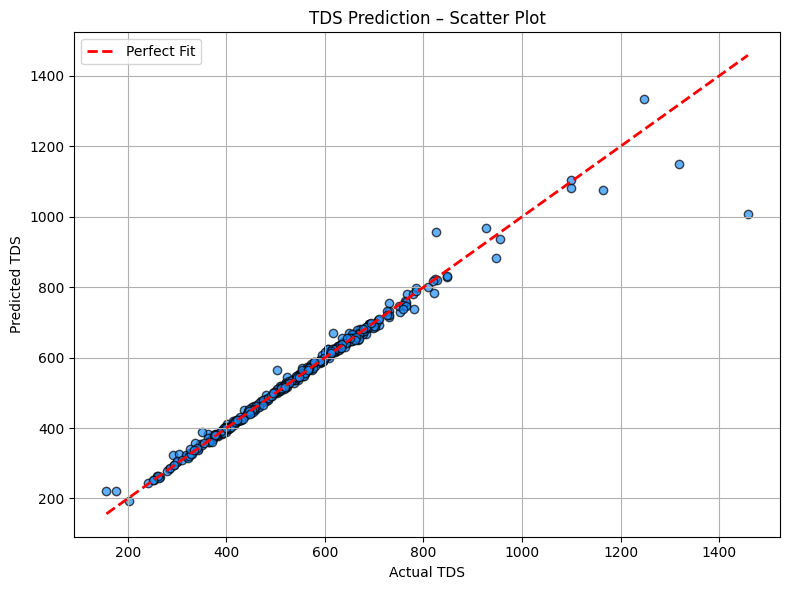

In [5]:
# 📊 Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"📉 MAE: {mae:.2f}")
print(f"📉 RMSE: {rmse:.2f}")
print(f"🧠 R² Score: {r2:.4f}")

# ✨ Scatter Plot
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.7, c='dodgerblue', edgecolors='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel("Actual TDS")
plt.ylabel("Predicted TDS")
plt.title("TDS Prediction – Scatter Plot")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
#  Save Mode
joblib.dump(model, "tds_regre_forecast_model.pkl")

['tds_regre_forecast_model.pkl']

/tmp/ipykernel_36/2398984800.py:18: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127775 (\N{GLOWING STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


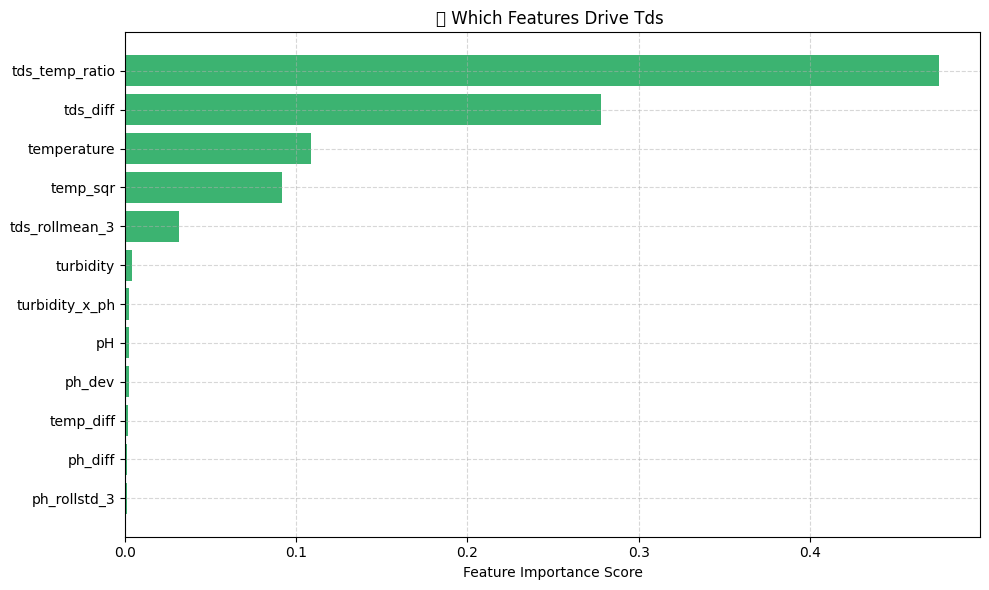

In [7]:
import matplotlib.pyplot as plt

# Get feature importances from trained model
importances = model.feature_importances_
feature_names = X.columns

# Sort them
indices = np.argsort(importances)[::-1]
sorted_features = [feature_names[i] for i in indices]
sorted_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_importances[::-1], color='mediumseagreen')
plt.xlabel("Feature Importance Score")
plt.title("🌟 Which Features Drive Tds ")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()